# Model verification - Redis YCSB

In [1]:
from helpers.load_data import (
    clean_column_names,
    get_data_with_cpu,
    get_experiments_paths,
    remove_setup_datapoints,
    trim_experiment,
)
from helpers.regression import (
    boxplot_two,
    boxplot_grid,
    draw_regression_graph,
    fit_regression,
)
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm


plt.style.use('seaborn')

plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

experiments_path = '../../data/basic'

## Redis YCSB vs Redis YCSB

In [2]:
instances_n=12
experiment_name='redis_ycsb_1_redis_ycsb_11'
workload_a = 'redis_ycsb'
workload_b = 'redis_ycsb'
perf_metric = 'app_latency'
path = get_experiments_paths(experiment_name, experiments_path)[0]
df = get_data_with_cpu(path, instances_n=instances_n, cpu_window=30)
df['time'] = pd.to_datetime(df['cbtool_time'], unit='s')

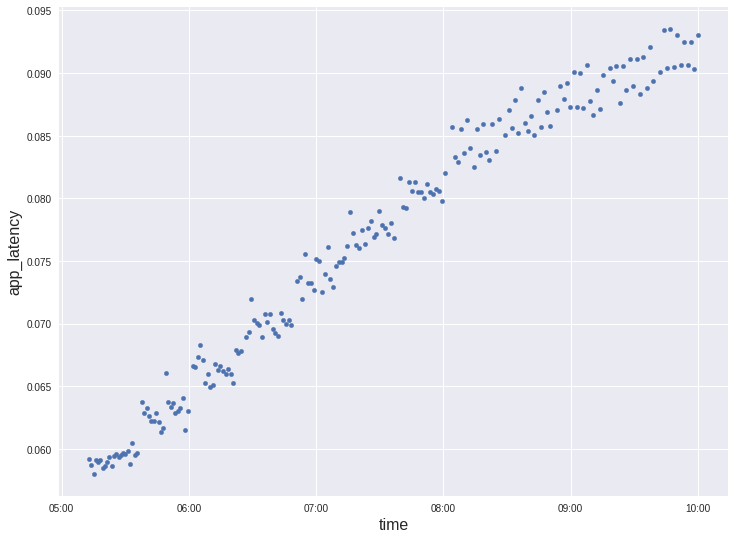

In [3]:
ax = df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.savefig(f'graphs/{experiment_name}_perf_time_scatter_before_cleaning.png', bbox_inches='tight')

In [4]:
df = remove_setup_datapoints(df, path)

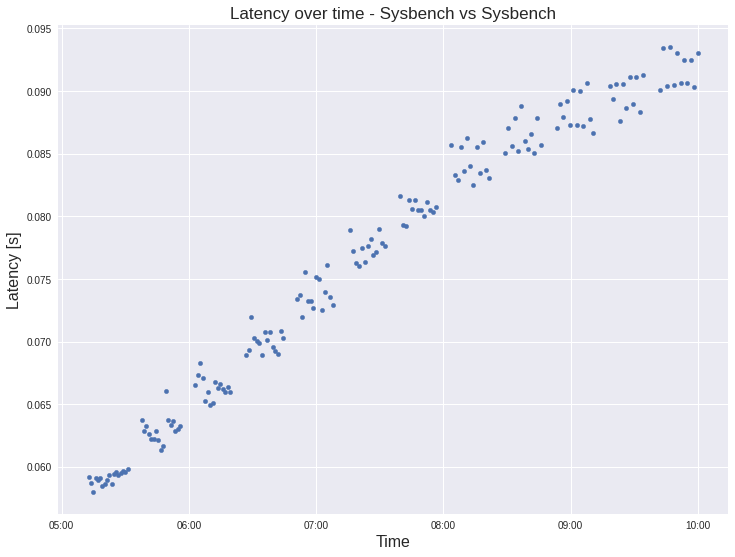

In [5]:
ax = df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.set_title('Latency over time - Sysbench vs Sysbench')
ax.set_ylabel('Latency [s]')
ax.set_xlabel('Time')
plt.savefig(f'graphs/{experiment_name}_perf_time_scatter.png', bbox_inches='tight')

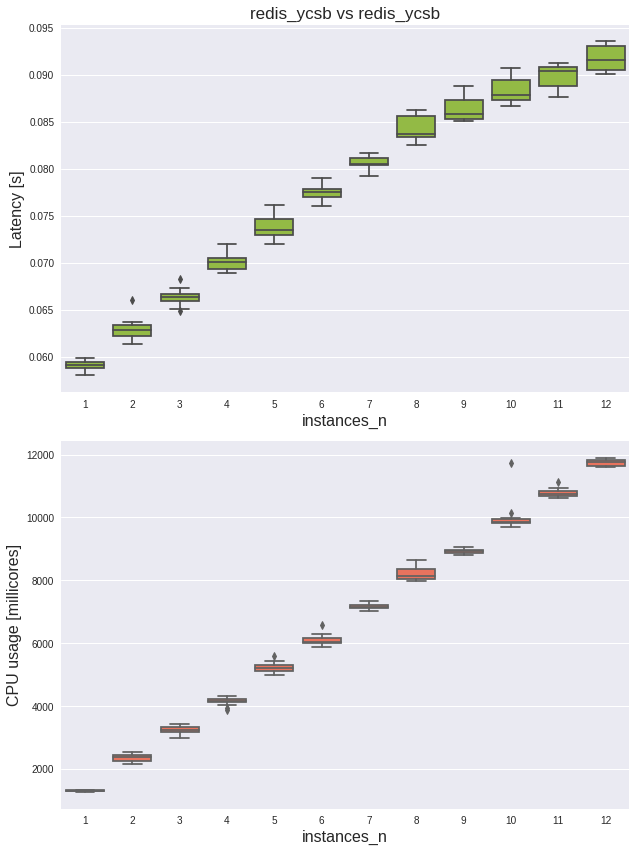

In [6]:
boxplot_two(perf_metric, 'cpu', df, (9,12), title=f'{workload_a} vs {workload_b}', ylab_1='Latency [s]', ylab_2='CPU usage [millicores]')
# plt.savefig(f'graphs/{experiment_name}_perf+cpu.png', bbox_inches='tight')

plt.tight_layout()
plt.savefig(f'graphs/{experiment_name}_perf+cpu.eps', format='eps')

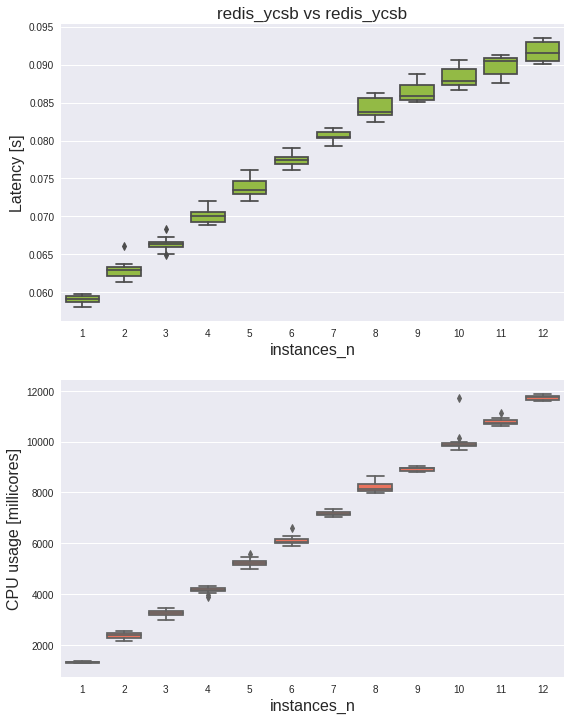

In [7]:
boxplot_two(perf_metric, 'cpu', df, (9,12), title=f'{workload_a} vs {workload_b}', ylab_1='Latency [s]', ylab_2='CPU usage [millicores]')
plt.savefig(f'graphs/{experiment_name}_perf+cpu.png', bbox_inches='tight')

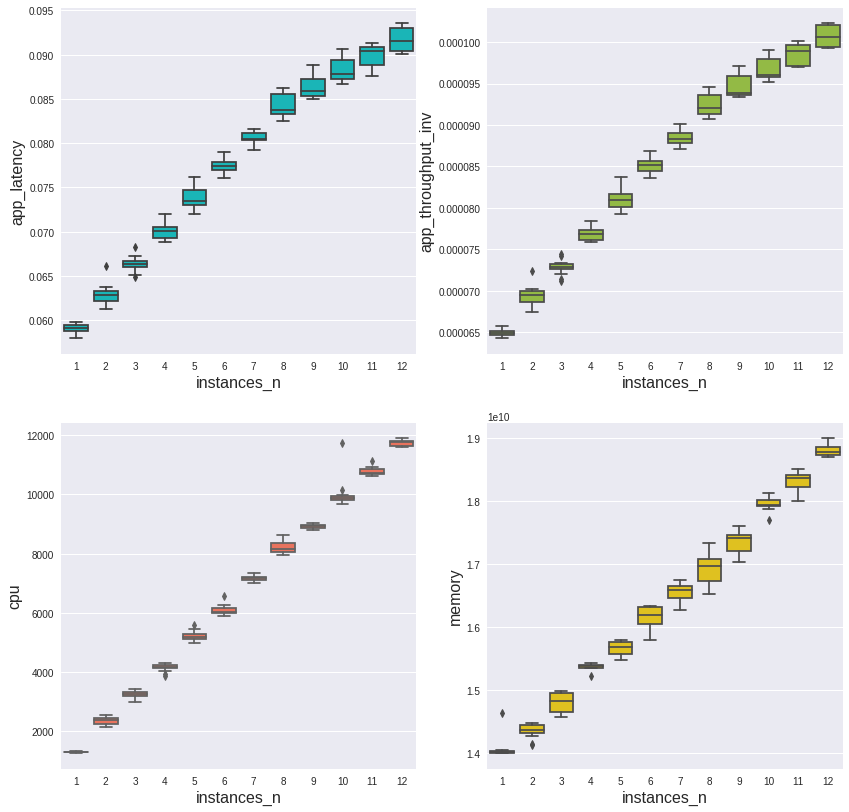

In [8]:
boxplot_grid(
    var_names=[['app_latency', 'app_throughput_inv'], ['cpu', 'memory']],
    figsize=[14, 14],
    dfs=[[df, df], [df, df]],
    titles=None,
    ylabels=None,
    suptitle=None
)

### Regression - whole experiment

In [9]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     6403.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          9.62e-133
Time:                        23:13:17   Log-Likelihood:                 816.69
No. Observations:                 165   AIC:                            -1629.
Df Residuals:                     163   BIC:                            -1623.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0575      0.000    214.424      

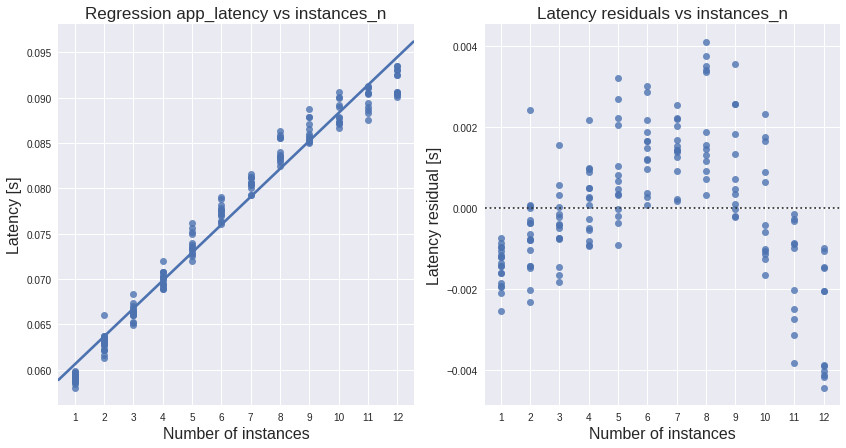

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='instances_n', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')
ax1.set_xlabel('Number of instances')
ax1.set_xticks(range(1,13))

sns.residplot(x='instances_n', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')
ax2.set_xlabel('Number of instances')
ax2.set_xticks(range(1,13))

pass
# plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.png', bbox_inches='tight')

### Regression - trimmed

In [11]:
trim=8
df = trim_experiment(df, trim)

In [12]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     9143.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          3.54e-112
Time:                        23:13:17   Log-Likelihood:                 655.92
No. Observations:                 118   AIC:                            -1308.
Df Residuals:                     116   BIC:                            -1302.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0557      0.000    307.704      

In [13]:
for table in results.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &   app\_latency   & \textbf{  R-squared:         } &     0.987  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.987  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     9143.  \\
\textbf{Date:}             & Wed, 31 Aug 2022 & \textbf{  Prob (F-statistic):} & 3.54e-112  \\
\textbf{Time:}             &     23:13:17     & \textbf{  Log-Likelihood:    } &    655.92  \\
\textbf{No. Observations:} &         118      & \textbf{  AIC:               } &    -1308.  \\
\textbf{Df Residuals:}     &         116      & \textbf{  BIC:               } &    -1302.  \\
\textbf{Df Model:}         &           1      & \textbf{                     } &            \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &            \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{center}
\begin{center}
\begin{tabu

In [14]:
print(f'Coefficient for instances_n: {results.params[1]:.6f}')

Coefficient for instances_n: 0.003585


#### Pvalues

In [15]:
results.pvalues

Intercept      8.979638e-171
instances_n    3.536496e-112
dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


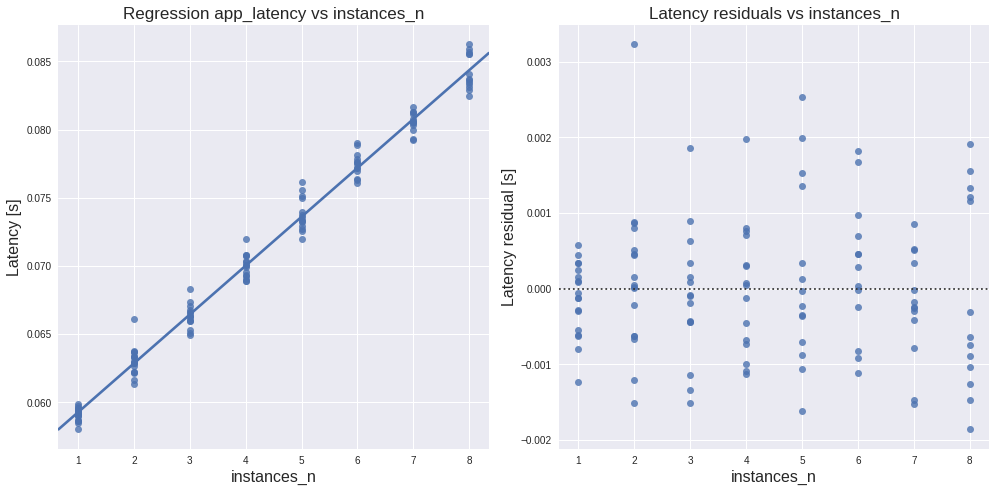

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='instances_n', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')
ax1.set_xticks(range(1,9))

sns.residplot(x='instances_n', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')
ax2.set_xticks(range(1,9))

# plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.png', bbox_inches='tight')
plt.tight_layout()
plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.eps', format='eps')

#### Regression - CPU

In [17]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     6270.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          8.07e-103
Time:                        23:13:18   Log-Likelihood:                 634.00
No. Observations:                 118   AIC:                            -1264.
Df Residuals:                     116   BIC:                            -1258.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0546      0.000    236.379      0.0

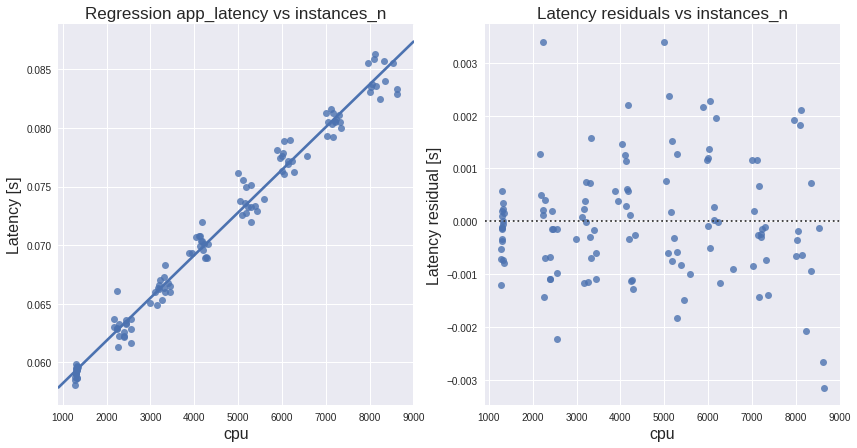

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='cpu', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')

sns.residplot(x='cpu', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')

pass
# plt.savefig(f'graphs/{experiment_name}_cpu_regplot_residplot.png', bbox_inches='tight')

#### Regression - Memory

In [19]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     3066.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           2.85e-85
Time:                        23:13:18   Log-Likelihood:                 592.91
No. Observations:                 118   AIC:                            -1182.
Df Residuals:                     116   BIC:                            -1176.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0565      0.002    -24.511      0.0

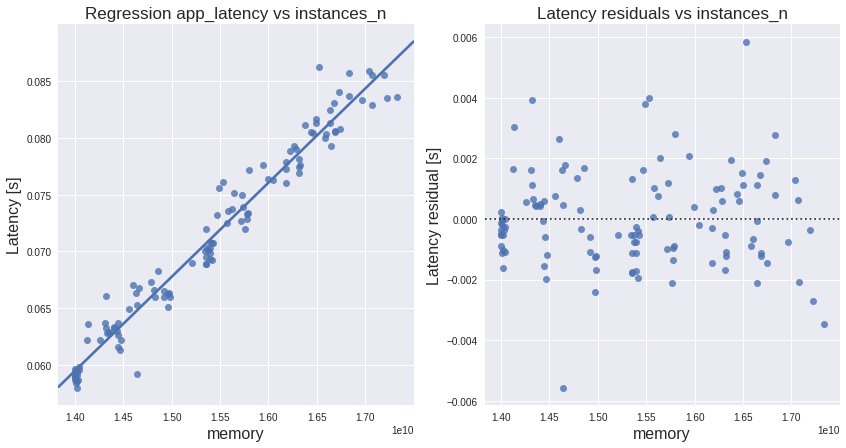

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='memory', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')

sns.residplot(x='memory', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')

pass
# plt.savefig(f'graphs/{experiment_name}_memory_regplot_residplot.png', bbox_inches='tight')

#### Mixed

In [21]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     4570.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          2.67e-110
Time:                        23:13:18   Log-Likelihood:                 656.39
No. Observations:                 118   AIC:                            -1307.
Df Residuals:                     115   BIC:                            -1298.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0559      0.000    213.452      

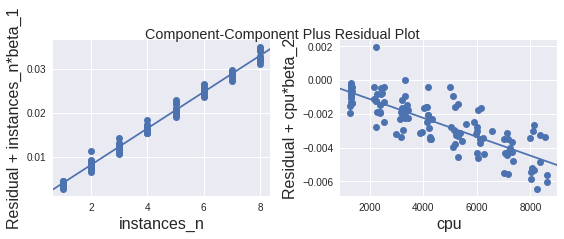

In [22]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

In [23]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu + memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     3022.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          1.97e-108
Time:                        23:13:19   Log-Likelihood:                 656.43
No. Observations:                 118   AIC:                            -1305.
Df Residuals:                     114   BIC:                            -1294.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0579      0.008      7.383      

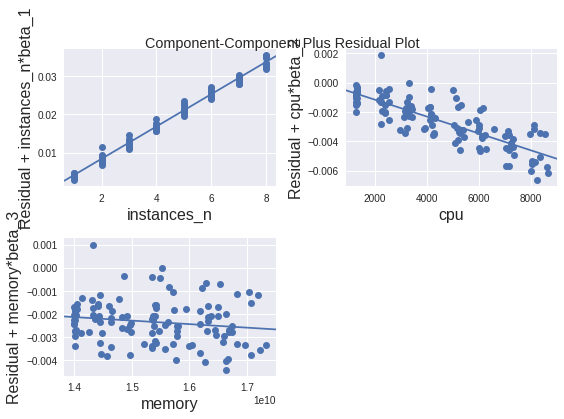

In [24]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

## Redis YCSB vs Linpack

In [25]:
instances_n=12
experiment_name='redis_ycsb_1_linpack_11'
workload_a = 'redis_ycsb'
workload_b = 'linpack'
perf_metric = 'app_latency'
path = get_experiments_paths(experiment_name, experiments_path)[0]
df = get_data_with_cpu(path, instances_n=instances_n, cpu_window=30)
df['time'] = pd.to_datetime(df['cbtool_time'], unit='s')

<AxesSubplot:xlabel='time', ylabel='app_latency'>

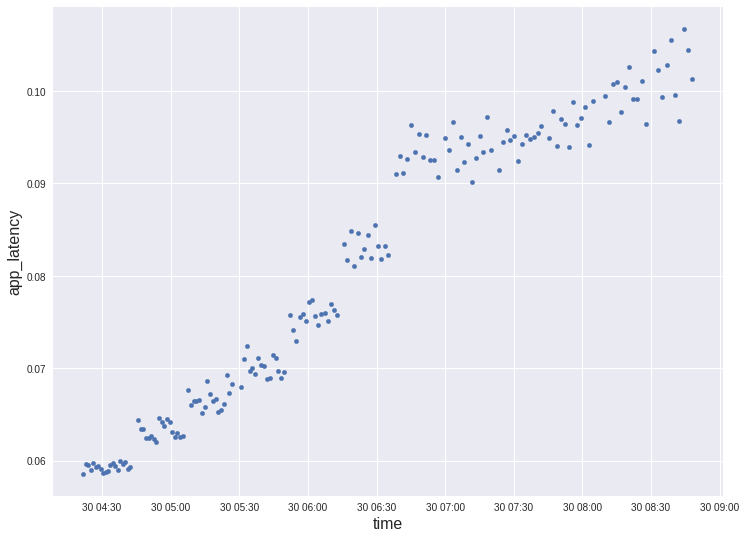

In [26]:
df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter.png', bbox_inches='tight')

In [27]:
df = remove_setup_datapoints(df, path)

<AxesSubplot:xlabel='time', ylabel='app_latency'>

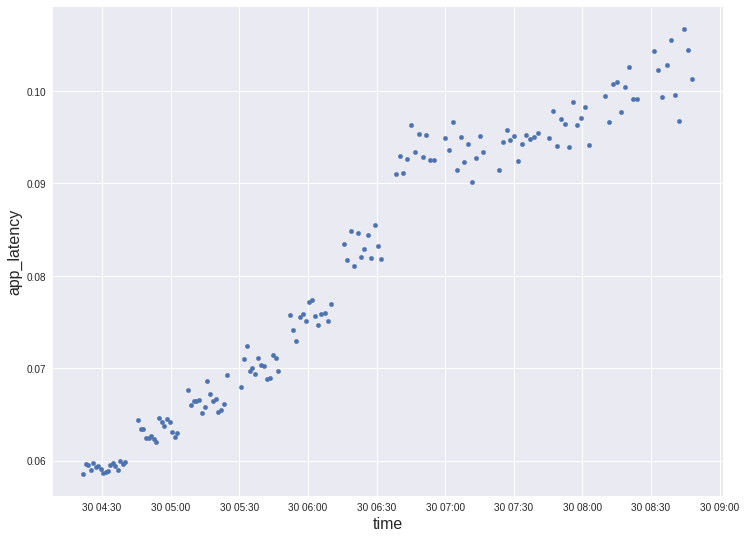

In [28]:
df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter.png', bbox_inches='tight')

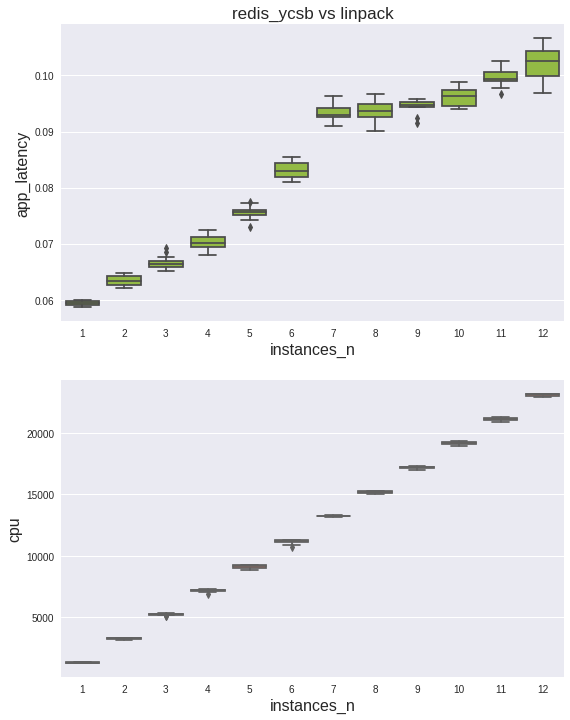

In [29]:
boxplot_two(perf_metric, 'cpu', df, (9,12), title=f'{workload_a} vs {workload_b}')
# plt.savefig(f'graphs/{experiment_name}_perf+cpu.png', bbox_inches='tight')

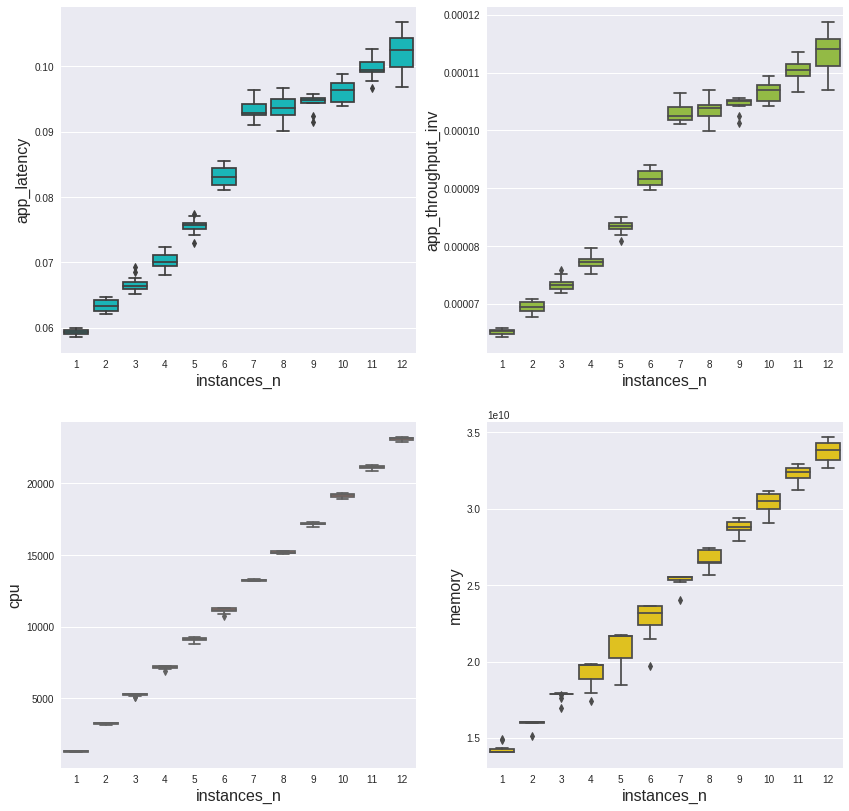

In [30]:
boxplot_grid(
    var_names=[['app_latency', 'app_throughput_inv'], ['cpu', 'memory']],
    figsize=[14, 14],
    dfs=[[df, df], [df, df]],
    titles=None,
    ylabels=None,
    suptitle=None
)

### Regression - whole experiment

In [31]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     2920.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          3.14e-100
Time:                        23:13:22   Log-Likelihood:                 651.48
No. Observations:                 152   AIC:                            -1299.
Df Residuals:                     150   BIC:                            -1293.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0555      0.001    104.209      

In [32]:
# h = df[['app_latency', 'cpu', 'memory', 'instances_n', 'app_completion_time']].head(5)
# t = df[['app_latency', 'cpu', 'memory', 'instances_n', 'app_completion_time']].tail(5)
# print(h.append(t).to_latex())

# for table in results.summary().tables:
#     print(table.as_latex_tabular())

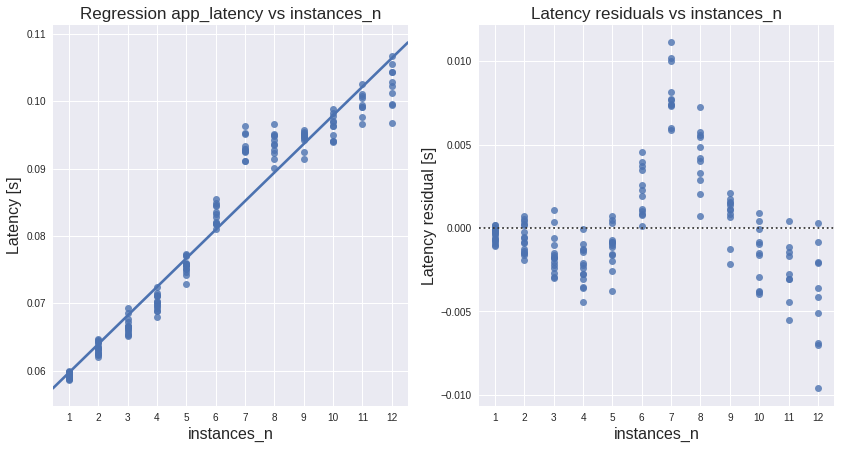

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='instances_n', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')
ax1.set_xticks(range(1,13))

sns.residplot(x='instances_n', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')
ax2.set_xticks(range(1,13))

pass
# plt.savefig(f'graphs/{experiment_name}.png', bbox_inches='tight')

### Regression - trimmed

In [34]:
trim=5
df = trim_experiment(df, trim)

In [35]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     2021.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           5.40e-56
Time:                        23:13:22   Log-Likelihood:                 416.91
No. Observations:                  77   AIC:                            -829.8
Df Residuals:                      75   BIC:                            -825.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0553      0.000    197.727      

In [36]:
# for table in results.summary().tables:
#     print(table.as_latex_tabular())

In [37]:
print(f'Coefficient for instances_n: {results.params[1]:.6f}')

Coefficient for instances_n: 0.003920


#### Pvalues

In [38]:
results.pvalues

Intercept      1.101612e-103
instances_n     5.404062e-56
dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


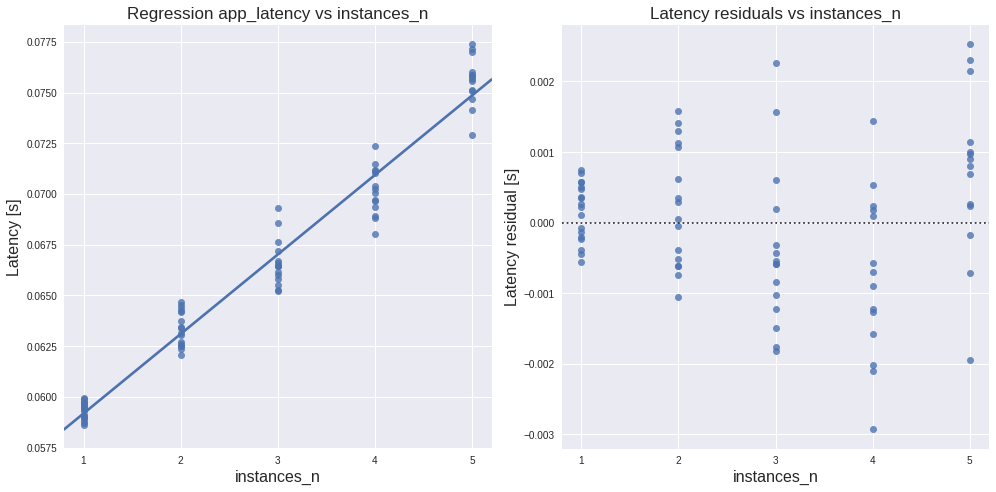

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='instances_n', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')
ax1.set_xticks(range(1,6))

sns.residplot(x='instances_n', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')
ax2.set_xticks(range(1,6))

# plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.png', bbox_inches='tight')
plt.tight_layout()
plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.eps', format='eps')

#### Regression - CPU

In [40]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1972.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           1.30e-55
Time:                        23:13:23   Log-Likelihood:                 416.00
No. Observations:                  77   AIC:                            -828.0
Df Residuals:                      75   BIC:                            -823.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0566      0.000    220.207      0.0

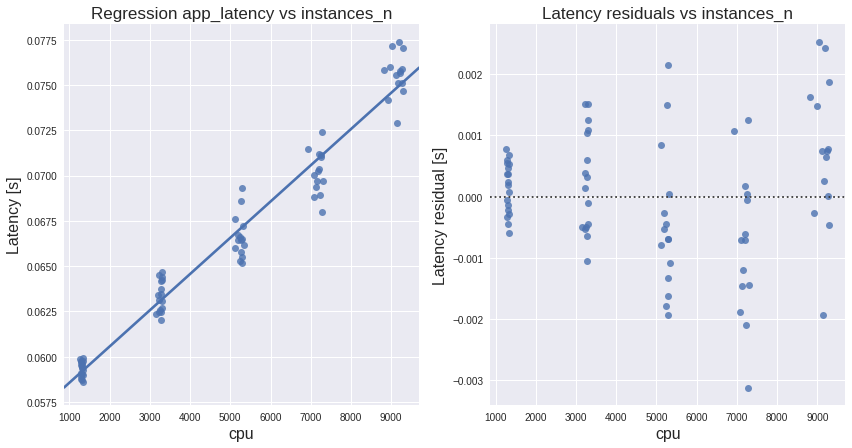

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='cpu', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')

sns.residplot(x='cpu', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')

pass
# plt.savefig(f'graphs/{experiment_name}_cpu_regplot_residplot.png', bbox_inches='tight')

#### Regression - Memory

In [42]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     754.7
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           6.88e-41
Time:                        23:13:23   Log-Likelihood:                 381.23
No. Observations:                  77   AIC:                            -758.5
Df Residuals:                      75   BIC:                            -753.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0282      0.001     20.040      0.0

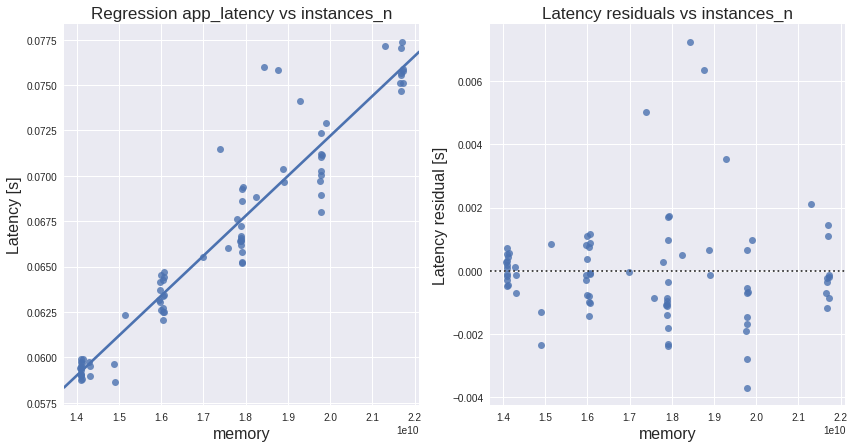

In [43]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='memory', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')

sns.residplot(x='memory', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')

pass
# plt.savefig(f'graphs/{experiment_name}_memory_regplot_residplot.png', bbox_inches='tight')

#### Mixed

In [44]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     997.1
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           3.06e-54
Time:                        23:13:23   Log-Likelihood:                 416.91
No. Observations:                  77   AIC:                            -827.8
Df Residuals:                      74   BIC:                            -820.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0553      0.001     53.984      

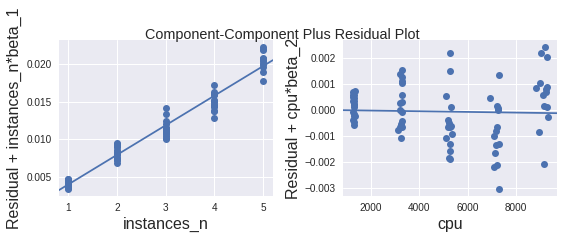

In [45]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

In [46]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu + memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     682.9
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           2.62e-53
Time:                        23:13:24   Log-Likelihood:                 418.42
No. Observations:                  77   AIC:                            -828.8
Df Residuals:                      73   BIC:                            -819.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0472      0.005      9.758      

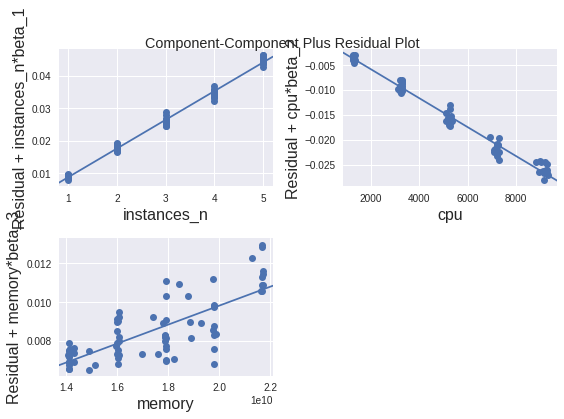

In [47]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

## Redis YCSB vs Sysbench

In [48]:
instances_n=12
experiment_name='redis_ycsb_1_sysbench_11'
workload_a = 'redis_ycsb'
workload_b = 'sysbench'
perf_metric = 'app_latency'
path = get_experiments_paths(experiment_name, experiments_path)[1]
df = get_data_with_cpu(path, instances_n=instances_n, cpu_window=30)
df['time'] = pd.to_datetime(df['cbtool_time'], unit='s')

<AxesSubplot:xlabel='time', ylabel='app_latency'>

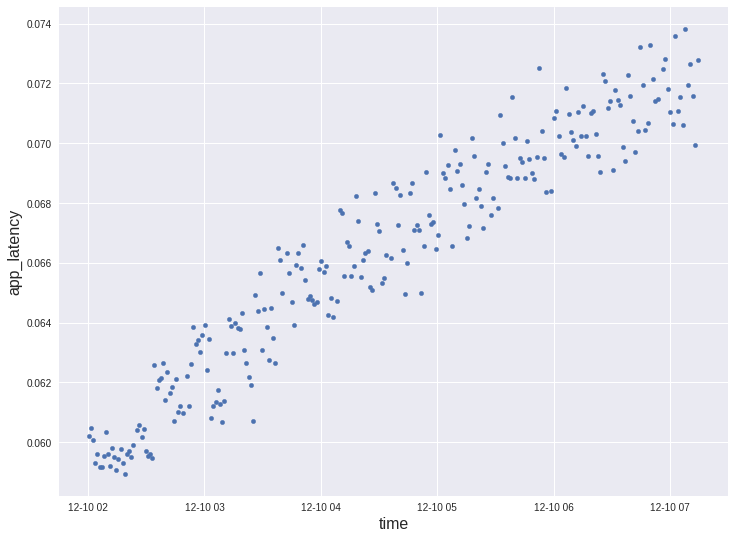

In [49]:
df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter.png', bbox_inches='tight')

In [50]:
df = remove_setup_datapoints(df, path)

<AxesSubplot:xlabel='time', ylabel='app_latency'>

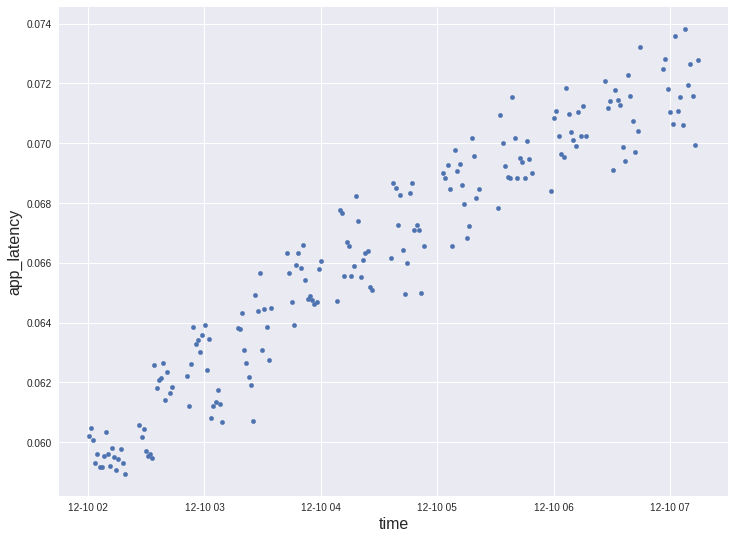

In [51]:
df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter.png', bbox_inches='tight')

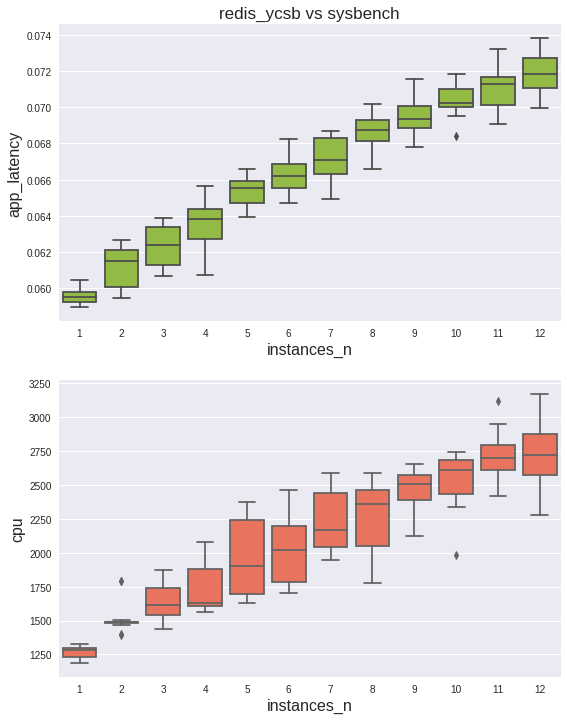

In [52]:
boxplot_two(perf_metric, 'cpu', df, (9,12), title=f'{workload_a} vs {workload_b}')
# plt.savefig(f'graphs/{experiment_name}_perf+cpu.png', bbox_inches='tight')

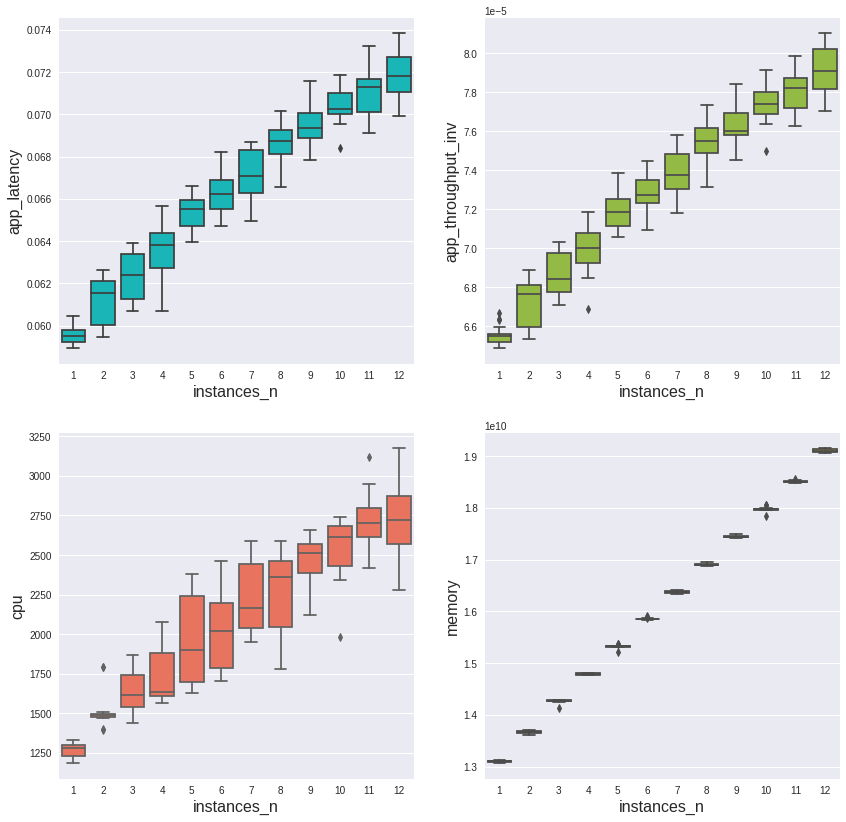

In [53]:
boxplot_grid(
    var_names=[['app_latency', 'app_throughput_inv'], ['cpu', 'memory']],
    figsize=[14, 14],
    dfs=[[df, df], [df, df]],
    titles=None,
    ylabels=None,
    suptitle=None
)

### Regression - whole experiment

In [54]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     2432.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          1.71e-109
Time:                        23:13:27   Log-Likelihood:                 1026.9
No. Observations:                 190   AIC:                            -2050.
Df Residuals:                     188   BIC:                            -2043.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0591      0.000    357.425      

In [55]:
# for table in results.summary().tables:
#     print(table.as_latex_tabular())

In [56]:
print(f'Coefficient for instances_n: {results.params[1]:.6f}')

Coefficient for instances_n: 0.001128


#### Pvalues

In [57]:
results.pvalues

Intercept      2.995971e-268
instances_n    1.709771e-109
dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


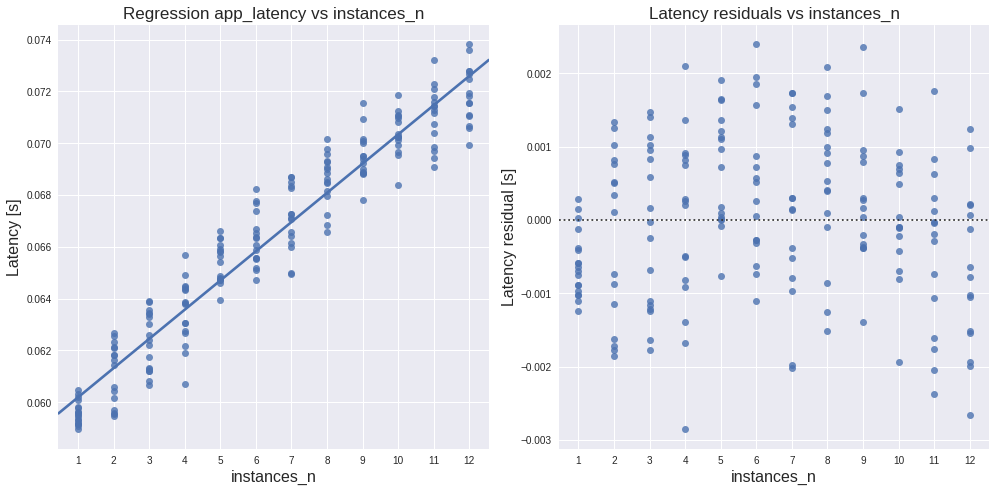

In [58]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='instances_n', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')
ax1.set_xticks(range(1,13))

sns.residplot(x='instances_n', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')
ax2.set_xticks(range(1,13))

# plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.png', bbox_inches='tight')
plt.tight_layout()
plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.eps', format='eps')

#### Regression - CPU

In [59]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     649.0
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           7.11e-63
Time:                        23:13:28   Log-Likelihood:                 918.47
No. Observations:                 190   AIC:                            -1833.
Df Residuals:                     188   BIC:                            -1826.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0514      0.001     85.718      0.0

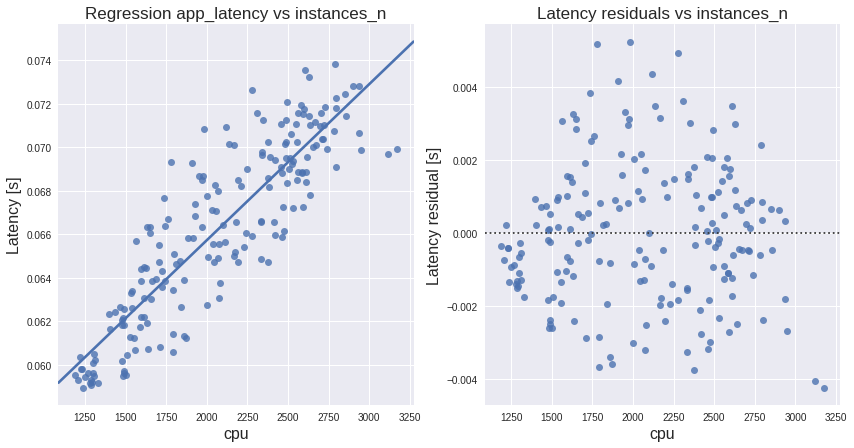

In [60]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='cpu', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')

sns.residplot(x='cpu', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')

pass
# plt.savefig(f'graphs/{experiment_name}_cpu_regplot_residplot.png', bbox_inches='tight')

#### Regression - Memory

In [61]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     2447.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          9.87e-110
Time:                        23:13:28   Log-Likelihood:                 1027.4
No. Observations:                 190   AIC:                            -2051.
Df Residuals:                     188   BIC:                            -2044.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0327      0.001     47.886      0.0

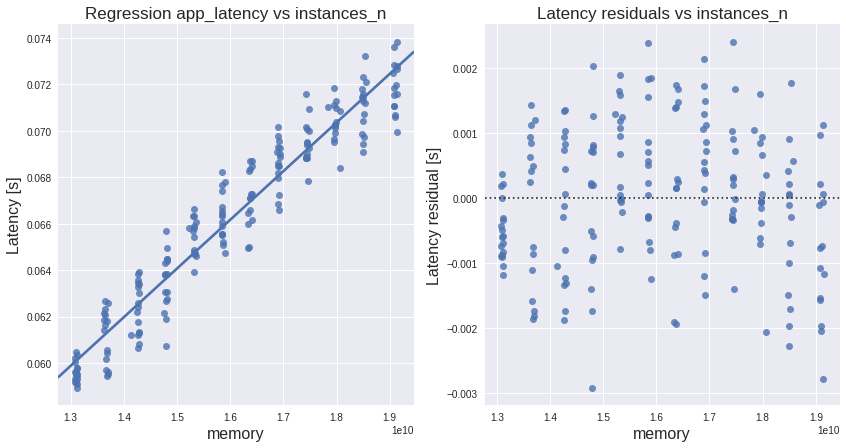

In [62]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='memory', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')

sns.residplot(x='memory', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')

pass
# plt.savefig(f'graphs/{experiment_name}_memory_regplot_residplot.png', bbox_inches='tight')

#### Mixed

In [63]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     1210.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          1.02e-107
Time:                        23:13:28   Log-Likelihood:                 1026.9
No. Observations:                 190   AIC:                            -2048.
Df Residuals:                     187   BIC:                            -2038.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0592      0.001    114.119      

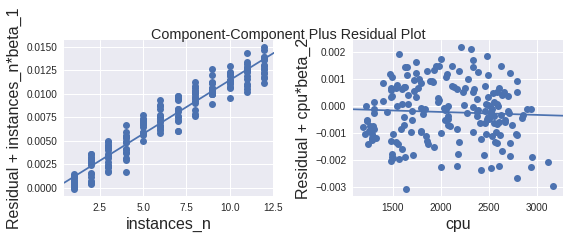

In [64]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

In [65]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu + memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     807.4
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          2.34e-106
Time:                        23:13:29   Log-Likelihood:                 1027.5
No. Observations:                 190   AIC:                            -2047.
Df Residuals:                     186   BIC:                            -2034.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0314      0.027      1.177      

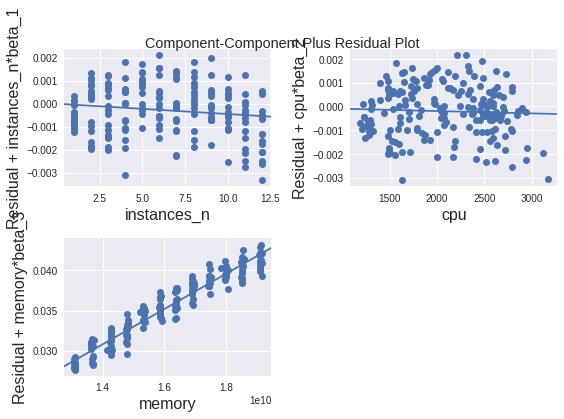

In [66]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

## Redis YCSB vs Hadoop

In [67]:
instances_n=8
experiment_name='redis_ycsb_d_1_hadoop_pagerank_7'
workload_a = 'redis_ycsb'
workload_b = 'hadoop'
perf_metric = 'app_latency'
path = get_experiments_paths(experiment_name, experiments_path)[0]
df = get_data_with_cpu(path, instances_n=instances_n, cpu_window=30)
df['time'] = pd.to_datetime(df['cbtool_time'], unit='s')

<AxesSubplot:xlabel='time', ylabel='app_latency'>

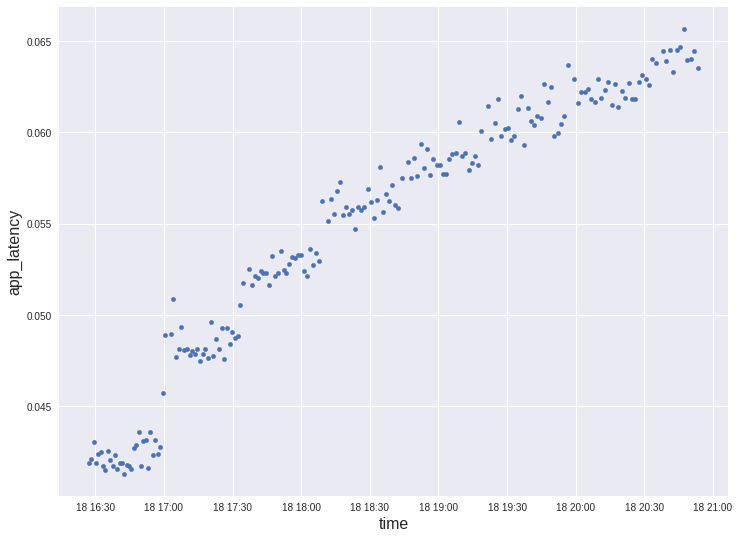

In [68]:
df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter.png', bbox_inches='tight')

In [69]:
df = remove_setup_datapoints(df, path, year=2021)

<AxesSubplot:xlabel='time', ylabel='app_latency'>

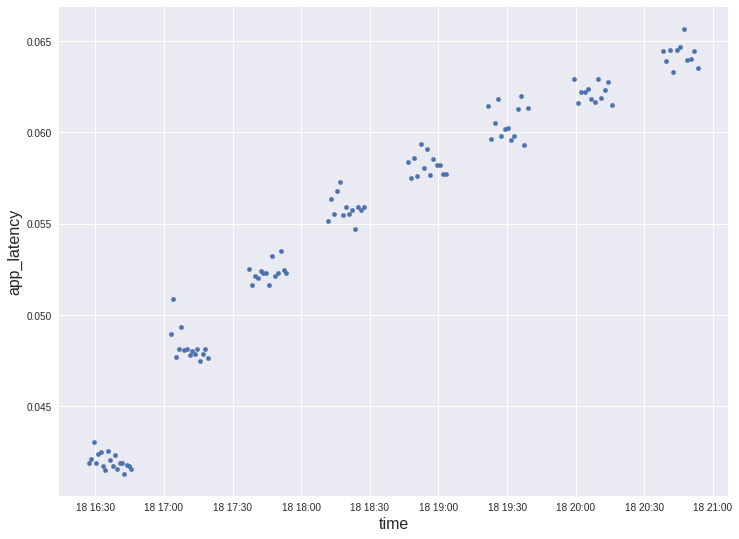

In [70]:
df.plot.scatter(x='time', y=perf_metric, figsize=(12, 9))
# plt.savefig(f'graphs/{experiment_name}_perf_time_scatter.png', bbox_inches='tight')

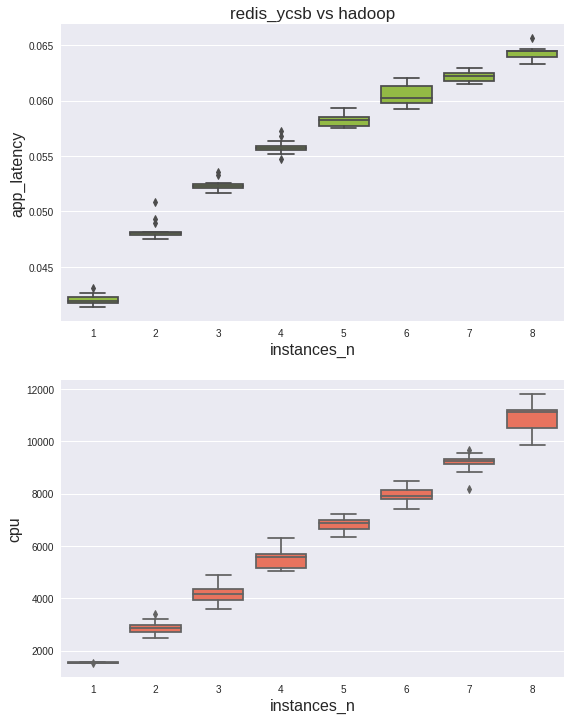

In [71]:
boxplot_two(perf_metric, 'cpu', df, (9,12), title=f'{workload_a} vs {workload_b}')
# plt.savefig(f'graphs/{experiment_name}_perf+cpu.png', bbox_inches='tight')

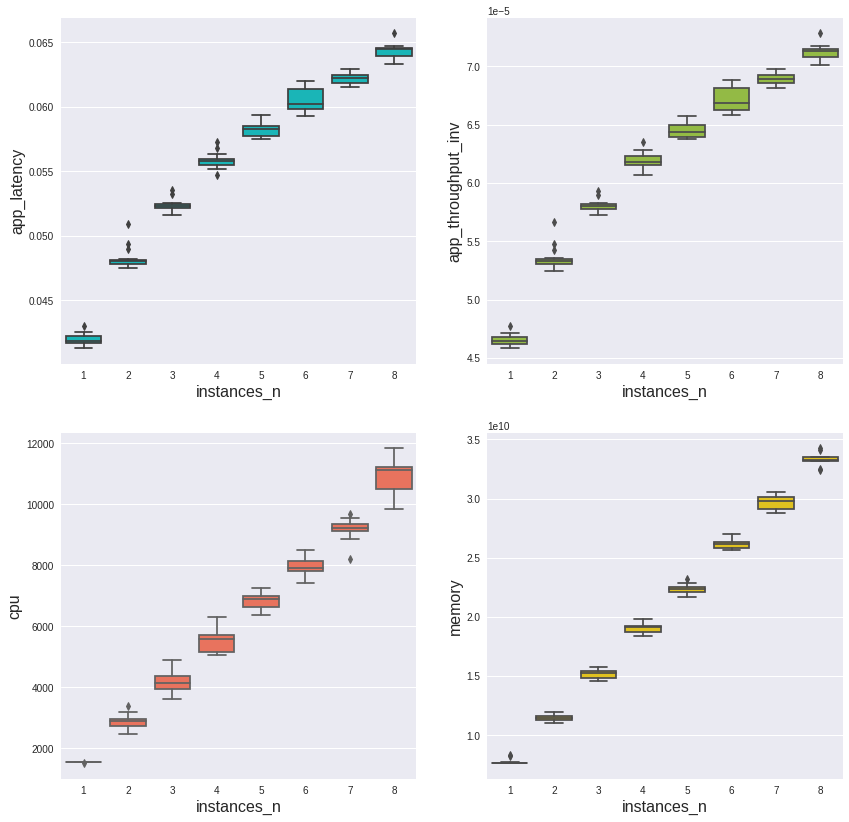

In [72]:
boxplot_grid(
    var_names=[['app_latency', 'app_throughput_inv'], ['cpu', 'memory']],
    figsize=[14, 14],
    dfs=[[df, df], [df, df]],
    titles=None,
    ylabels=None,
    suptitle=None
)

### Regression - whole experiment

In [73]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1826.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           1.71e-69
Time:                        23:13:31   Log-Likelihood:                 541.58
No. Observations:                 110   AIC:                            -1079.
Df Residuals:                     108   BIC:                            -1074.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0413      0.000    118.755      

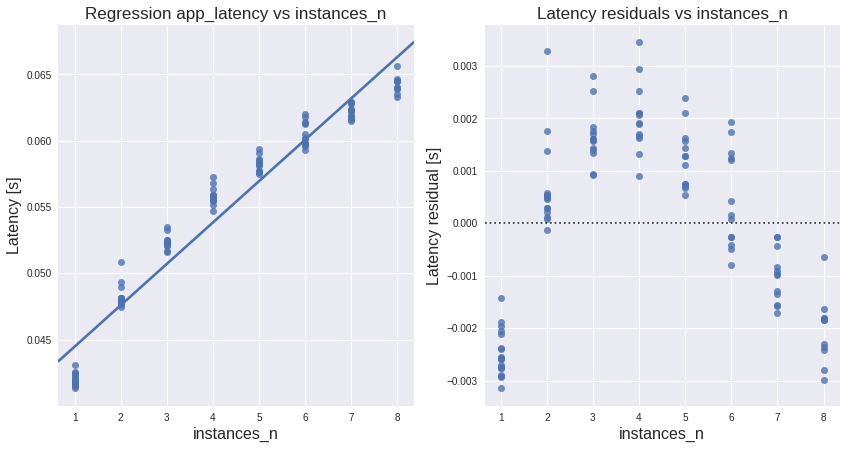

In [74]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='instances_n', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')
ax1.set_xticks(range(1,9))

sns.residplot(x='instances_n', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')
ax2.set_xticks(range(1,9))

pass
# plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.png', bbox_inches='tight')

### Regression - trimmed

In [75]:
trim=6
df = trim_experiment(df, trim)

In [76]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1741.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           2.13e-58
Time:                        23:13:32   Log-Likelihood:                 446.73
No. Observations:                  87   AIC:                            -889.5
Df Residuals:                      85   BIC:                            -884.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0399      0.000    121.155      

In [77]:
print(f'Coefficient for instances_n: {results.params[1]:.6f}')

Coefficient for instances_n: 0.003689


In [78]:
df.loc[:,'predicted_latency'] = results.params[0] + df['instances_n'] * results.params[1]
df['error'] = df['predicted_latency'] - df['app_latency']
df['error'].apply(abs)
df['relative_error'] = df['error'] / df['app_latency']
print(f'Maximal relative error: {df["relative_error"].max() * 100}%')
print(f'Average relative error: {df["relative_error"].mean() * 100}%')

Maximal relative error: 5.4361818977178284%
Average relative error: 0.1118177875270362%


In [79]:
# for table in results.summary().tables:
#     print(table.as_latex_tabular())

#### Pvalues

In [80]:
results.pvalues

Intercept      5.583727e-97
instances_n    2.132407e-58
dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


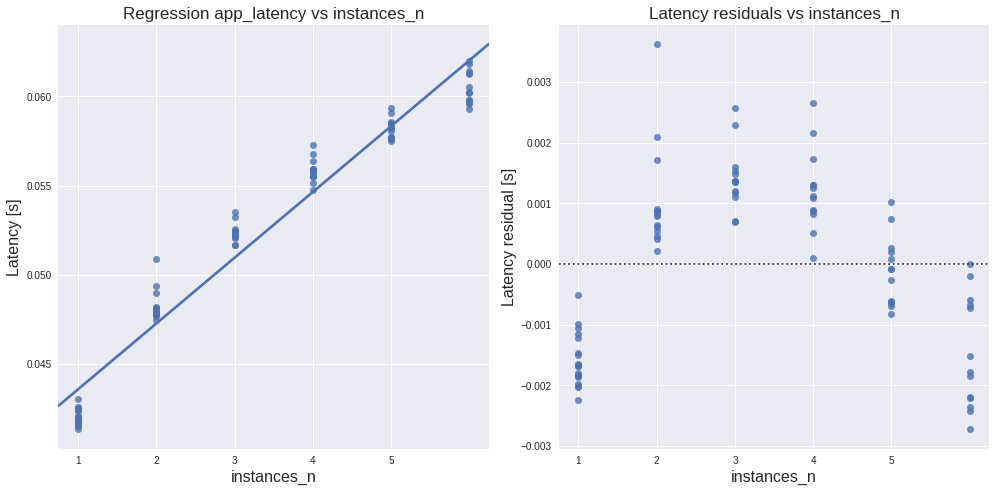

In [81]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='instances_n', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')
ax1.set_xticks(range(1,6))

sns.residplot(x='instances_n', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')
ax2.set_xticks(range(1,6))

# plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.png', bbox_inches='tight')
plt.tight_layout()
plt.savefig(f'graphs/{experiment_name}_instances_n_regplot_residplot.eps', format='eps')

#### Regression - CPU

In [82]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1384.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           2.22e-54
Time:                        23:13:32   Log-Likelihood:                 437.27
No. Observations:                  87   AIC:                            -870.5
Df Residuals:                      85   BIC:                            -865.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0393      0.000    102.414      0.0

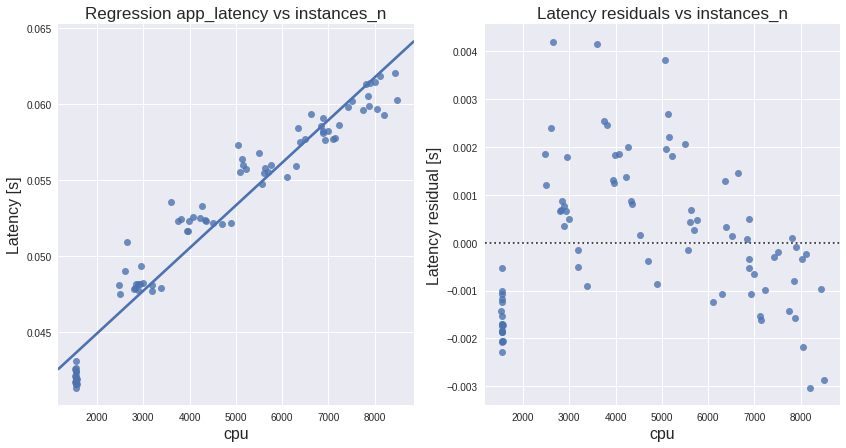

In [83]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='cpu', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')

sns.residplot(x='cpu', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')

pass
# plt.savefig(f'graphs/{experiment_name}_cpu_regplot_residplot.png', bbox_inches='tight')

#### Regression - Memory

In [84]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1680.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           9.10e-58
Time:                        23:13:33   Log-Likelihood:                 445.25
No. Observations:                  87   AIC:                            -886.5
Df Residuals:                      85   BIC:                            -881.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0358      0.000     84.255      0.0

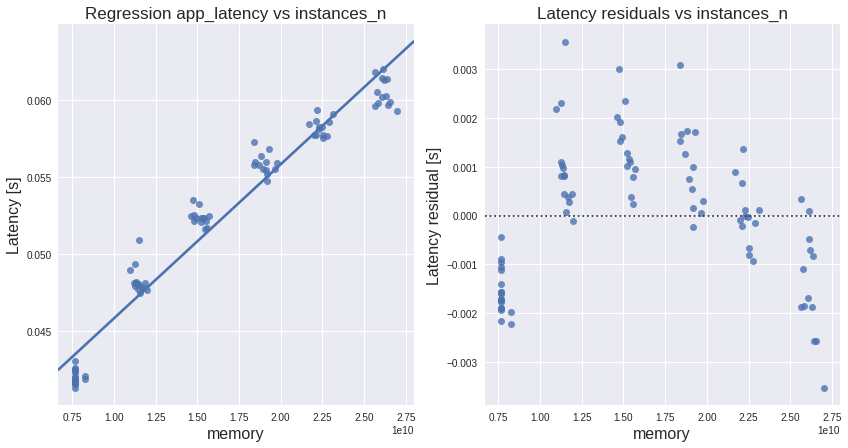

In [85]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.regplot(x='memory', y=perf_metric, data=df, ax=ax1, truncate=False, ci=None)
ax1.set_title(f'Regression {perf_metric} vs instances_n')
ax1.set_ylabel(f'Latency [s]')

sns.residplot(x='memory', y=perf_metric, data=df, ax=ax2)
ax2.set_title(f'Latency residuals vs instances_n')
ax2.set_ylabel(f'Latency residual [s]')

pass
# plt.savefig(f'graphs/{experiment_name}_memory_regplot_residplot.png', bbox_inches='tight')

#### Regression - mixed

In [86]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     864.1
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           9.44e-57
Time:                        23:13:33   Log-Likelihood:                 446.91
No. Observations:                  87   AIC:                            -887.8
Df Residuals:                      84   BIC:                            -880.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0398      0.000    109.327      

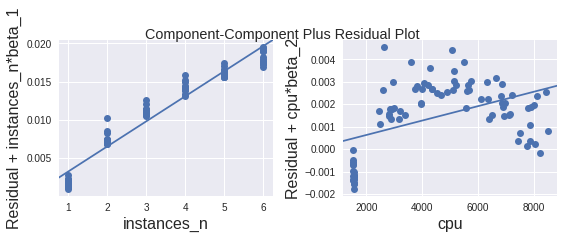

In [87]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)

In [88]:
results = fit_regression(data=df, formula=f'{perf_metric} ~ instances_n + cpu + memory')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            app_latency   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     569.5
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           3.07e-55
Time:                        23:13:33   Log-Likelihood:                 446.93
No. Observations:                  87   AIC:                            -885.9
Df Residuals:                      83   BIC:                            -876.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0394      0.002     19.549      

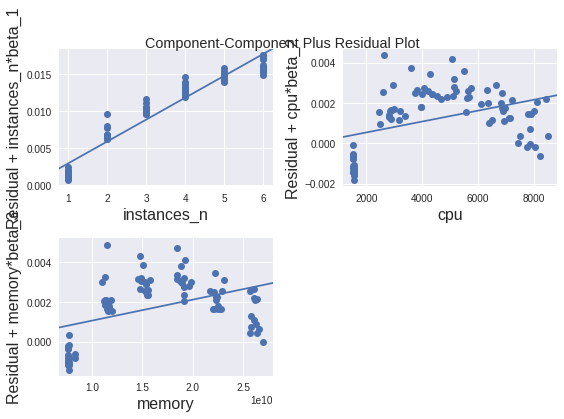

In [89]:
sm.graphics.plot_ccpr_grid(results)
fig.tight_layout(pad=1.0)